In [3]:
import spacy 
from spacy import displacy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
import os

import extract_relationship_script as exr


In [4]:
# Load the language model and set the max_length to 2 million characters
NER = spacy.load("en_core_web_sm")
NER.max_length = 0

In [5]:
# A legend for the entity types found by the model
#
# PERSON:      People, including fictional.
# NORP:        Nationalities or religious or political groups.
# FAC:         Buildings, airports, highways, bridges, etc.
# ORG:         Companies, agencies, institutions, etc.
# GPE:         Countries, cities, states.
# LOC:         Non-GPE locations, mountain ranges, bodies of water.
# PRODUCT:     Objects, vehicles, foods, etc. (Not services.)
# EVENT:       Named hurricanes, battles, wars, sports events, etc.
# WORK_OF_ART: Titles of books, songs, etc.
# LAW:         Named documents made into laws.
# LANGUAGE:    Any named language.
# DATE:        Absolute or relative dates or periods.
# TIME:        Times smaller than a day.
# PERCENT:     Percentage, including ”%“.
# MONEY:       Monetary values, including unit.
# QUANTITY:    Measurements, as of weight or distance.
# ORDINAL:     “first”, “second”, etc.
# CARDINAL:    Numerals that do not fall under another type.

In [6]:
files = [f for f in os.scandir('archive') if '.txt' in f.name]
files

[<DirEntry 'got0.txt'>,
 <DirEntry 'got1.txt'>,
 <DirEntry 'got2.txt'>,
 <DirEntry 'got3.txt'>,
 <DirEntry 'got4.txt'>]

In [7]:
file = files[0]
file_text = open(file, encoding='utf-8').read()
NER.max_length = len(file_text)
# Give the text in input to the NER model, output will be {text: entities}
file_doc = NER(file_text)
displacy.render(file_doc[:100], style='ent', jupyter=True)

In [8]:
# Read the characters dataframe generated by the "character_scraping.ipynb" script
characters_df = pd.read_csv('D:\VS codici\Codici Python\Project GOT\character_list.csv')

# Knowing that in many cases, in the book, the characters are referred by their alias or only the first name,
# In the name column i consider only the first name of the character
characters_df['Name'] = characters_df['Name'].apply(lambda x: x.split(' ')[0])
characters_df
    

,Name,Alias
0,Eddard,Ned
1,Robert,NaN
2,Jaime,NaN
3,Catelyn,NaN
4,Cersei,NaN
5,Daenerys,NaN
6,Jorah,NaN
7,Viserys,NaN
8,Jon,NaN
9,Robb,NaN


In [9]:
# A function to filter all the entities found by the model and keep only those which are in the "characters" dataframe
# Input: entity_list: list of entities found by the model, characters_df: dataframe with all the important characters
# Output: filtered_list: list of entities found by the model which are in the "characters" dataframe
def filter_entity(entity_list, characters_df):
    filtered_list = []
    for entity in entity_list:
        if entity in characters_df['Name'].values:
            filtered_list.append(entity)
        elif entity in characters_df['Alias'].values:
            # If the entity is an alias, i use the name instead
            corresponding_name = characters_df[characters_df['Alias'] == entity]['Name'].values[0]
            filtered_list.append(corresponding_name)
    return filtered_list

In [10]:
#Test the filter function
filter_entity(["Ned", 'Snow', 1, 'Stark'], characters_df)

['Eddard']

In [11]:
# List of dictionaries {sentence: entities in the sentence}
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
# .sents consent to split the text in sentences and iterate over it
for sent in tqdm(file_doc.sents):
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)
sent_entity_df

0it [00:00, ?it/s]

23823it [22:24, 17.72it/s]


,sentence,entities
0,"(A, Game, of, Thrones, \n\n, A, Bantam, Spectr...","[SPECTRA, Bantam Books, Random House, Inc., Ba..."
1,"(Heraldic, crests, by, Virginia, Norey, ., \n\n)",[Virginia Norey]
2,"(All, rights, reserved, ., \n\n)",[]
3,"(Copyright, ©, 1996, by, George, R., R., Marti...","[1996, George R. R. Martin, Congress]"
4,"(Number, :, 95, -, 43936, ., \n\n)",[95-43936]
...,...,...
23818,"(ACKNOWLEDGMENTS, \n\n\n, The, devil, is, in, ...",[]
23819,"(A, book, this, size, has, a, lot, of, devils,...",[]
23820,"(Fortunately, ,, I, know, a, lot, of, angels, ...",[]
23821,"(Thanks, and, appreciation, ,, therefore, ,, t...","[Sage Walker, Martin Wright, Melinda Snodgrass..."


In [12]:
# Apply the filter function to the entities found in each sentence
sent_entity_df['characters_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters_df))

# Filter the sentences which don't contain any character
sent_entity_filtered = sent_entity_df[sent_entity_df['characters_entities'].map(len) > 0]
sent_entity_filtered
# migliorabile

,sentence,entities,characters_entities
336,"(“, For, Robert, !, ”)",[Robert],[Robert]
386,"(Robb, and, Jon, sat, tall, and, still, on, th...","[Jon, older than seven]",[Jon]
420,"(“, You, did, well, ,, ”, Jon, told, him, sole...",[Jon],[Jon]
421,"(Jon, was, fourteen, ,, an, old, hand, at, jus...","[Jon, fourteen]",[Jon]
431,"(Jon, ’s, eyes, were, a, grey, so, dark, they,...",[Jon],[Jon]
...,...,...,...
23744,"(EDDARD, STARK, ,, Lord, of, Winterfell, ,, Wa...","[Winterfell, Warden, North, House Tully, Winte...","[Bran, Sansa]"
23749,"(The, Lannister, words, are, Hear, Me, Roar, !...","[Lannister, Hear Me Roar, Casterly Rock, Warde...","[Cersei, Jaime]"
23809,"(129–131, Aegon, II, eldest, son, of, Viserys,...","[129–131, Aegon, Viserys, Aegon II’s, Rhaenyra...",[Viserys]
23814,"(161–171, Baelor, I, the, Beloved, ,, the, Ble...","[161–171, Beloved, Blessed, septon, king, seco...",[Viserys]


### Create relationships:

Iterate over sentences using a 'moving window' and create a relationship between characters that appear in this window.

In [13]:
# Create relationships
window_size = 5
relationships = []

# iterate over all the sentences
for i in range(0, sent_entity_filtered.index[-1]):

    # to not have an index out of range errors at the end
    end_i = min(sent_entity_filtered.index[-1],i + window_size)

    # put all the characters that appear in the window in a list (sum of lists is concatenation)
    char_list = sum((sent_entity_filtered['characters_entities'][i:end_i]), [])

    #remove relationship between the same character (cast to set to remove duplicates and then back to list)
    char_unique = list(set(char_list))

    # if there are more than 1 character in the window, create all the sequential relationships
    if len(char_unique) > 1:
        for index, char_a in enumerate(char_unique[:-1]):
            char_b = char_unique[index + 1]
            relationships.append({'source': char_a, 'target': char_b})

# Create dataframe using the list of relationships
relationships_df = pd.DataFrame(relationships)

# sort the relationships b->a and a->b to have a unique relationship for each pair of characters
relationships_df = pd.DataFrame(np.sort(relationships_df, axis=1), columns=relationships_df.columns)
relationships_df

,source,target
0,Jon,Robert
1,Jon,Robb
2,Jon,Robb
3,Jon,Robb
4,Jon,Robb
...,...,...
5543,Bran,Sansa
5544,Sansa,Viserys
5545,Jaime,Viserys
5546,Cersei,Viserys


In [14]:
relationships_df['value'] = 1

# Group the ocurrences of a relationship
relationships_df = relationships_df.groupby(['source', 'target'], sort=False, as_index=False).sum()

# a dataframe witch contains source, target and value can be called a edge list
# we want that alias and name are considered as the same character

# drop the rows where value is less than 5
relationships_df = relationships_df[relationships_df['value'] >= 5]

relationships_df


,source,target,value
0,Jon,Robert,71
1,Jon,Robb,88
2,Bran,Robb,55
3,Bran,Jon,53
4,Catelyn,Jon,47
...,...,...,...
172,Jaime,Tywin,5
178,Bronn,Shae,22
179,Shae,Tyrion,14
185,Jorah,Sansa,5


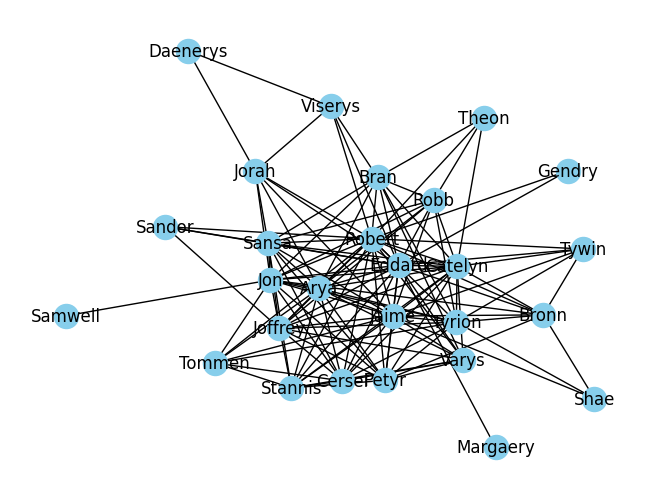

In [15]:
# Visualize network
Graph = nx.from_pandas_edgelist(relationships_df, 'source', 'target', edge_attr= 'value', create_using=nx.Graph())
pos = nx.kamada_kawai_layout(Graph)
nx.draw(Graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Reds, pos = pos)

it can be seen that the graph formed by the relationships between characters in game of thrones is very dense and (as will be seen later) does not have characters more central than others.

In [16]:
from pyvis.network import Network
net = Network(notebook=True, height='1000px', width= '700px', bgcolor='#222222', font_color='white', cdn_resources= 'remote')
net.repulsion()

net.from_nx(Graph)

node_degrees = dict(Graph.degree())
nx.set_node_attributes(Graph, node_degrees, 'size')
nx.set_node_attributes(Graph, node_degrees, 'label')

net.save_graph("networkx-pyvis.html")

In [17]:
# Auxiliary function to bar-plot the top n characters by ...
def my_plot_top_n(centrality_dict: dict, title: str, top_n: int, color: str = 'skyblue'):
    degree_centrality_df = pd.DataFrame.from_dict(centrality_dict, orient='index', columns=['degree_centrality'])
    degree_centrality_df.sort_values(by='degree_centrality', ascending=False)[:top_n].plot.bar(figsize=(10, 5), title=title, color=color)
    plt.show()

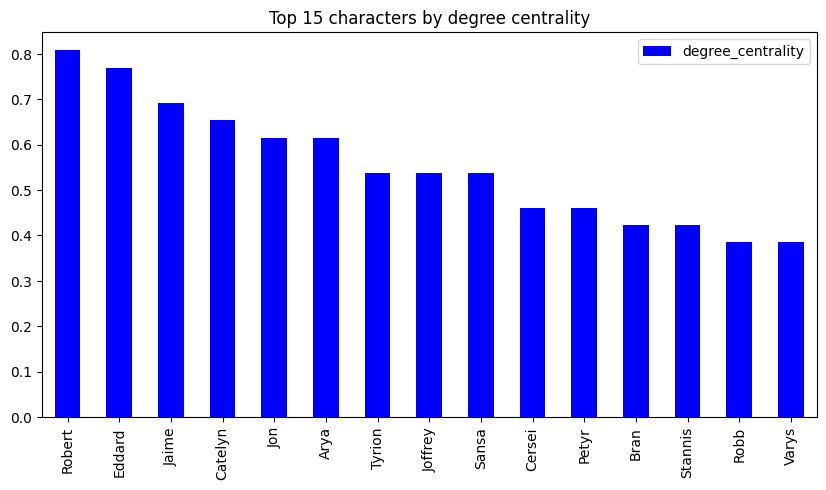

,degree
Jon,0.615385
Robert,0.807692
Robb,0.384615
Bran,0.423077
Catelyn,0.653846
Eddard,0.769231
Sansa,0.538462
Viserys,0.192308
Daenerys,0.076923
Jorah,0.307692


In [18]:
# Extract the most important characters based on the degree centrality measure

degree_centrality = nx.degree_centrality(Graph)
my_plot_top_n(degree_centrality, 'Top 15 characters by degree centrality', 15, color='blue')
degree_centrality_df = pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['degree'])
degree_centrality_df.reset_index().rename(columns={'index': 'Name'})
degree_centrality_df

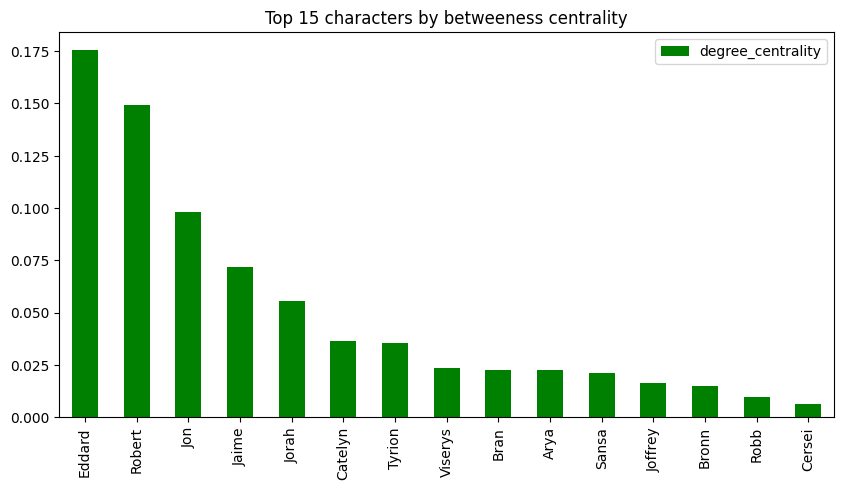

In [19]:
# Rating characters using the betweeness centrality measure
# 
betweeness_centrality = nx.betweenness_centrality(Graph)
betweeness_centrality_df = pd.DataFrame.from_dict(betweeness_centrality, orient='index', columns=['betweeness'])
degree_centrality_df.reset_index().rename(columns={'index': 'Name'})
my_plot_top_n(betweeness_centrality, 'Top 15 characters by betweeness centrality', 15, color='green')

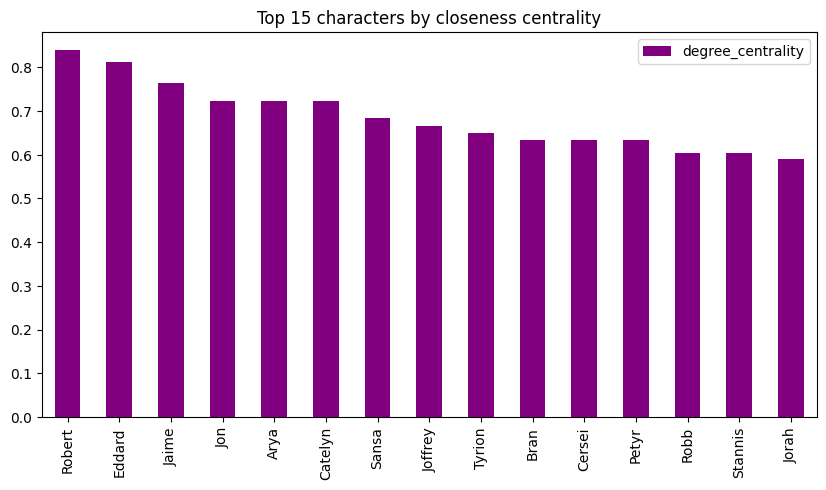

In [20]:
# Rating characters using the closeness centrality measure

closeness_centrality = nx.closeness_centrality(Graph)
closeness_centrality_df = pd.DataFrame.from_dict(closeness_centrality, orient='index', columns=['closeness'])
closeness_centrality_df.reset_index().rename(columns={'index': 'Name'})
my_plot_top_n(closeness_centrality, 'Top 15 characters by closeness centrality', 15, color='purple')

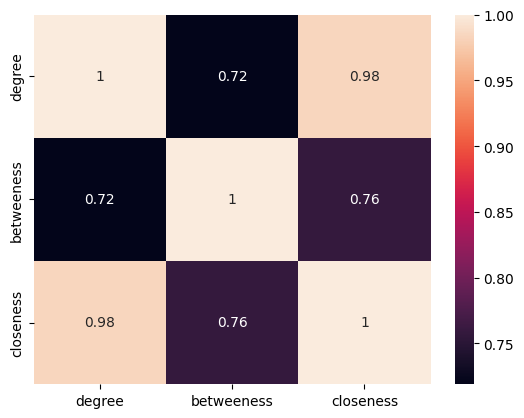

In [21]:
# Create a table with all centrality measures for each character and visualize the correlation matrix
import seaborn as sb
centrality_df_Book_0 = pd.DataFrame({'degree': degree_centrality, 'betweeness': betweeness_centrality, 'closeness': closeness_centrality})
corr_matrix = sb.heatmap(centrality_df_Book_0.corr(),cbar=True, annot=True)

In [22]:
centrality_dfs = []
book0_centrality = pd.DataFrame(index = characters_df['Name'].values, columns = {
                                 'degree': np.zeros(len(characters_df['Name'])),
                                 'betweeness': np.zeros(len(characters_df['Name'])),
                                 'closeness': np.zeros(len(characters_df['Name']))
                                 }
                                 )

In [23]:
book0_centrality['degree'] = degree_centrality_df['degree']
book0_centrality['betweeness'] = betweeness_centrality_df['betweeness']
book0_centrality['closeness'] = closeness_centrality_df['closeness']
book0_centrality

,degree,betweeness,closeness
Eddard,0.769231,0.175393,0.812500
Robert,0.807692,0.149243,0.838710
Jaime,0.692308,0.071778,0.764706
Catelyn,0.653846,0.036321,0.722222
Cersei,0.461538,0.006230,0.634146
Daenerys,0.076923,0.000000,0.388060
Jorah,0.307692,0.055568,0.590909
Viserys,0.192308,0.023333,0.530612
Jon,0.615385,0.097990,0.722222
Robb,0.384615,0.009624,0.604651


In [24]:
#Extracting communities using Louvain method
nx.community.louvain_communities(Graph)

[{'Bran', 'Catelyn', 'Jon', 'Robb', 'Samwell', 'Sansa', 'Theon'},
 {'Arya', 'Cersei', 'Joffrey', 'Petyr', 'Stannis', 'Tommen', 'Varys'},
 {'Daenerys',
  'Eddard',
  'Gendry',
  'Jorah',
  'Margaery',
  'Robert',
  'Sandor',
  'Viserys'},
 {'Bronn', 'Jaime', 'Shae', 'Tyrion', 'Tywin'}]

*Notice that the first community found contains all characters related to the Stark family and the last one contains all characters related to the Lannister family*

***

For convenience and in order not to have to process the whole text each time, the edgelists of each book were saved as csv files.Thanks to this, graphs can be constructed and analyses can be carried out much more quickly.

<AxesSubplot: >

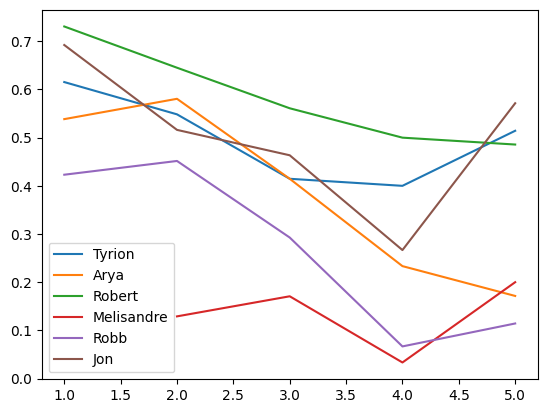

In [25]:
# Plotting the variation of degree centrality between books of certain characters

books_path = 'Codici Python/Project GOT/Archive'
edges_folder = 'D:\VS codici\Codici Python\Project GOT\Extracted_edges'
graph_list = []
files = [f.path for f in os.scandir(edges_folder)]
for file in files:
    a = pd.read_csv(file,sep=",")
    a = a.drop(a.columns[0], axis=1)
    graph_list.append(exr.create_graph(a))

evolutions = []
for g in graph_list:
    evolutions.append(nx.degree_centrality(g))
evolutions_df = pd.DataFrame.from_records(evolutions)
evolutions_df.index = [1,2,3,4,5]
evolutions_df.fillna(0)
evolutions_df[['Tyrion', 'Arya', 'Robert', 'Melisandre', 'Robb', 'Jon']].plot()